In [ ]:
##  TO-DO

# 1. Plot of pairMass1 vs pairMass2 for a) all pairs, b) all pairs when matchable, c) best pair (algo), d) best pair when matchable (algo)
# 2. Start calculating matching efficiencies for algorithms

In [47]:
import uproot, uproot_methods
import uproot_methods.classes.TLorentzVector as TLorentzVector
import matplotlib.pyplot as plt
import numpy as np
import itertools

t = 0.5  # transparency of plots

testRun = False
dR_cut_quarkToJet = 0.40
mass_higgs = 125.0 #GeV
width_higgs = 10.0 #GeV, reco width

In [2]:
delphes_hh= uproot.open('../../../MG5_aMC_v2_6_1/ppToHHto4b_14TeV/Events/run_02_decayed_1/tag_1_delphes_events.root')['Delphes']
#b_particles = uproot.tree.TBranchMethods.array(delphes_hh['Particle'])
#l_genD1     = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.D1']).tolist()
#l_genD2     = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.D2']).tolist()
l_genPID    = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.PID']).tolist()
l_genStatus = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Status']).tolist()
l_genPt     = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.PT']).tolist()
l_genEta    = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Eta']).tolist()
l_genPhi    = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Phi']).tolist()
l_genMass   = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Mass']).tolist()
l_jetPt     = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.PT']).tolist()
l_jetEta    = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Eta']).tolist()
l_jetPhi    = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Phi']).tolist()
l_jetMass   = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Mass']).tolist()


In [45]:
def plotOneHistogram(_arr, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins):
    #mean_arr = np.mean(arr)
    #stdev_arr = np.std(arr)
    #nEntries_arr = len(arr)

    #s1 = "Higgs Mass Reconstructed from 4 b-tagged jets:\n" \
    #     "entries = {}, mean = {:.4F}, std dev = {:.4F}".format(nEntries_arr, mean_arr, stdev_arr)

    plt.figure(_nPlot)
    plt.title(_title)
    plt.xlabel(_xtitle)
    _bins = np.linspace(_xMin, _xMax, _nBins)
    plt.hist(_arr, _bins, alpha=t)
    #plt.legend(loc='upper right')
    #plt.text(10, 10, s1)
    plt.show()

def compareTwoHistograms(_arrAll, _arrMatched, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins):
    #mean_arr = np.mean(arr)
    #stdev_arr = np.std(arr)
    #nEntries_arr = len(arr)

    #s1 = "Higgs Mass Reconstructed from 4 b-tagged jets:\n" \
    #     "entries = {}, mean = {:.4F}, std dev = {:.4F}".format(nEntries_arr, mean_arr, stdev_arr)

    plt.figure(_nPlot)
    plt.title(_title)
    plt.xlabel(_xtitle)
    _bins = np.linspace(_xMin, _xMax, _nBins)
    plt.hist(_arrAll, _bins, alpha=t, normed=True, label='All Events')
    plt.hist(_arrMatched, _bins, alpha=t, normed=True, label = 'Matched Events')
    plt.legend(loc='upper right')
    #plt.text(10, 10, s1)
    plt.show()

In [25]:
def returnListOfTruthBQuarkIndicesByDaughters(_D1, _D2, _PID):
    _bQuarkIndices = []
    
    for iParticle in range(0, len(_D1)):
         if _PID[iParticle]==25:
            _daughter1 = _D1[iParticle]
            _daughter2 = _D2[iParticle]
            _daughter1_PID = _PID[daughter1]
            _daughter2_PID = _PID[daughter2]
            #print('Event ',iEvt,'has higgs at position',iParticle,'with daughter1 (',daughter1,
            #    ') of PID',daughter1_PID,'and daughter2 (',daughter2,') of PID',daughter2_PID)
            if abs(_daughter1_PID) == 5 and abs(_daughter2_PID)==5:
                _bQuarkIndices.append(_daughter1)
                _bQuarkIndices.append(_daughter2)
    
    return _bQuarkIndices


def returnListOfTruthBQuarkIndicesByStatus(_status):
    _bQuarkIndices = []

    for iParticle in range(0, len(_status)):
        if _status[iParticle]==23:
            _bQuarkIndices.append(iParticle)

    return _bQuarkIndices

def returnNumberAndListOfJetIndicesPassingCuts(_jetPt, _jetEta, _cut_jetPt, _cut_jetEta):
    _jetIndices = []
    _nJets = 0
    
    for iJet in range(0, len(_jetPt)): 
        if _jetPt[iJet] > _cut_jetPt and abs(_jetEta[iJet]) < _cut_jetEta:
            _jetIndices.append(iJet)
            _nJets += 1
            
    return _nJets, _jetIndices

def getDictOfQuarksMatchedToJets(_quarkIndices, _jetIndices, _genPt, _genEta, _genPhi, _genMass, _jetPt, _jetEta, _jetPhi, _jetMass): 
    _matchedQuarksToJets = {}
    _dictOfJetVectors = {}
    _dictOfQuarkVectors = {}
    
    for iQuark in _quarkIndices:
        tlv_quark = TLorentzVector.PtEtaPhiMassLorentzVector( _genPt[iQuark], _genEta[iQuark], _genPhi[iQuark], _genMass[iQuark])
        if iQuark not in _dictOfQuarkVectors.keys():
            _dictOfQuarkVectors[iQuark] = tlv_quark
            
        for iJet in _jetIndices:
            tlv_jet = TLorentzVector.PtEtaPhiMassLorentzVector( _jetPt[iJet], _jetEta[iJet], _jetPhi[iJet], _jetMass[iJet])
            if iJet not in _dictOfJetVectors.keys():
                _dictOfJetVectors[iJet] = tlv_jet
        
            # skip jets
            if tlv_quark.delta_r( tlv_jet) > dR_cut_quarkToJet:
                continue

            if iQuark not in _matchedQuarksToJets.keys():
                _matchedQuarksToJets.update({iQuark:[iJet]})
            else:
                _matchedQuarksToJets[iQuark].append(iJet)

    return _matchedQuarksToJets, _dictOfJetVectors, _dictOfQuarkVectors

In [72]:
def getHarmonicMeanDeltaR(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _deltaR_pair1 = _jetVectorDict[_jetPairTuple[0]].delta_r(_jetVectorDict[_jetPairTuple[1]])
    _deltaR_pair2 = _jetVectorDict[_jetPairTuple[2]].delta_r(_jetVectorDict[_jetPairTuple[3]])
    
    # calculate the harmonic mean
    _meanDeltaR = np.reciprocal( ( np.reciprocal(_deltaR_pair1) + np.reciprocal(_deltaR_pair2) ) / 2 )
    #print(_jetPairTuple, _meanDeltaR, _deltaR_pair1, _deltaR_pair2)
    
    return _meanDeltaR
    

def getHiggsMassDifference(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _mass_pair1 = ( _jetVectorDict[_jetPairTuple[0]] + _jetVectorDict[_jetPairTuple[1]] ).mass 
    _mass_pair2 = ( _jetVectorDict[_jetPairTuple[2]] + _jetVectorDict[_jetPairTuple[3]] ).mass 
    
    # calculate the quadrature sum of higgs mass diff and divide by reco higgs width
    _quadratureMassDifference = np.sqrt( ( (_mass_pair1 - mass_higgs) / width_higgs )**2 + ( (_mass_pair2 - mass_higgs) / width_higgs )**2 )
    #print(_jetPairTuple, _quadratureMassDifference, _massDiff_pair1, _massDiff_pair2)
    
    return _quadratureMassDifference



def selectPairsViaMatchingAlgorithm(_jetVectorDict, _pairingAlgorithm):

    # make list of pairs from [n choose 2] where n is number of jets
    _jetPairs = list(itertools.combinations(_jetVectorDict.keys(),2))
    _doubleJetPairs = {}
    
    # loop over jet pairs
    for pair in _jetPairs:
        # make list of leftover pairs that do not contain either jet in starting pair
        _notPair = [x for x in list(_jetPairs) if pair[0] not in x and pair[1] not in x]
        for pairOption in _notPair:
            _sortedPairing = sorted([sorted(x) for x in [pair, pairOption]])
            _sortedTuple = tuple(_sortedPairing[0]+_sortedPairing[1])

            # add double pairing to dictionary if not already present. sorting removes positional ambiguity
            if _sortedTuple not in _doubleJetPairs.keys():
                _metric = 0
                _mass_pair1 = ( _jetVectorDict[_sortedTuple[0]] + _jetVectorDict[_sortedTuple[1]] ).mass 
                _mass_pair2 = ( _jetVectorDict[_sortedTuple[2]] + _jetVectorDict[_sortedTuple[3]] ).mass 
                # calculate metric depending on chosen algorithm
                if _pairingAlgorithm == "minHarmonicMeanDeltaR":
                     _metric = getHarmonicMeanDeltaR(_sortedTuple, _jetVectorDict)
                if _pairingAlgorithm == "higgsMassDifference":
                    _metric = getHiggsMassDifference(_sortedTuple, _jetVectorDict)
                
                # fill dicts/lists with calculated metric
                allHiggsMasses_metric.append( _mass_pair1 )
                allHiggsMasses_metric.append( _mass_pair2 )
                _doubleJetPairs[_sortedTuple] = [_metric, _mass_pair1, _mass_pair2]
                allJetPairs_metric.append( _metric )
                if thisEventIsMatchable:
                    allJetPairsWhenMatchable_metric.append( _metric )
                    allHiggsMassesWhenMatchable_metric.append( _mass_pair1 )
                    allHiggsMassesWhenMatchable_metric.append( _mass_pair2 )
                    
    # sort output dict and find minimal value
    _bestPairing = sorted(_doubleJetPairs.items(), key=lambda _pairingAndMetric: _pairingAndMetric[1][0])[0]
    bestJetPairs_metric.append(_bestPairing[1][0])
    bestHiggsMasses_metric.append(_bestPairing[1][1])
    bestHiggsMasses_metric.append(_bestPairing[1][2])

    if thisEventIsMatchable:
        bestJetPairsWhenMatchable_metric.append(_bestPairing[1][0])
        bestHiggsMassesWhenMatchable_metric.append(_bestPairing[1][1])
        bestHiggsMassesWhenMatchable_metric.append(_bestPairing[1][2])
    
    #print(_bestPairing[0], _bestPairing[1])
    
    return (_bestPairing[0][0], _bestPairing[0][1]), (_bestPairing[0][2] , _bestPairing[0][3])



In [75]:
nEventsWithExactly4Jets = 0
nEventsWithAtLeast4Jets = 0
nEventsWith4MatchableJets = 0
thisEventIsMatchable = False

allJetPairs_metric               = []
allJetPairsWhenMatchable_metric  = []
bestJetPairs_metric              = []
bestJetPairsWhenMatchable_metric = []

allHiggsMasses_metric               = []
allHiggsMassesWhenMatchable_metric  = []
bestHiggsMasses_metric              = []
bestHiggsMassesWhenMatchable_metric = []

pairingAlgorithm = 'higgsMassDifference' # options include: 1) minHarmonicMeanDeltaR, 2) higgsMassDifference 

for iEvt in range(0,delphes_hh.fEntries):
    # *** 0. Kick-out condition for testing
    if iEvt > 40 and testRun is True:
        continue
    if iEvt%2000==0:
        print("Analyzing event number",iEvt)
    
    # *** 1. Get truth information
    indicesByStatus    = returnListOfTruthBQuarkIndicesByStatus(l_genStatus[iEvt])   
    if len(indicesByStatus) != 4:
        print ("!!! WARNING: iEvt = {0} did not find 4 truth b-quarks. Only found {1} !!!".format(iEvt, len(indicesByStatus)))
        continue
        
    # *** 2. Get jet reco information
    nJets, jetIndices = returnNumberAndListOfJetIndicesPassingCuts(l_jetPt[iEvt], l_jetEta[iEvt], 20.0, 2.5)
    if nJets < 4: continue 
    nEventsWithAtLeast4Jets += 1
    if nJets==4: nEventsWithExactly4Jets += 1 

        
    # *** 3. Do some matching
    thisEventIsMatchable = False
    matchedQuarksToJets, jetVectorDict, quarkVectorDict = getDictOfQuarksMatchedToJets(indicesByStatus, jetIndices, l_genPt[iEvt], l_genEta[iEvt], l_genPhi[iEvt], l_genMass[iEvt], l_jetPt[iEvt], l_jetEta[iEvt], l_jetPhi[iEvt], l_jetMass[iEvt])
    #print( matchedQuarksToJets, all(len(matchedJets) == 1 for matchedJets in matchedQuarksToJets.values()) )
    if all(len(matchedJets) == 1 for matchedJets in matchedQuarksToJets.values()) and len(matchedQuarksToJets)==4:
        nEventsWith4MatchableJets += 1
        thisEventIsMatchable = True
    
    # *** 4. Pick two jet pairs based on some algorithm
    #print("!!!!!!", iEvt, thisEventIsMatchable)
    jetPair1, jetPair2 = selectPairsViaMatchingAlgorithm(jetVectorDict, pairingAlgorithm)
    
    
print("Number of Events with >= 4 jet:",nEventsWithAtLeast4Jets)
print("Number of Events with == 4 jet:",nEventsWithExactly4Jets)
print("Number of Events with 4 truth-matchable jets:",nEventsWith4MatchableJets)


Analyzing event number 0
Analyzing event number 2000
Analyzing event number 4000
Analyzing event number 6000
Analyzing event number 8000
Number of Events with >= 4 jet: 8164
Number of Events with == 4 jet: 2694
Number of Events with 4 truth-matchable jets: 4003


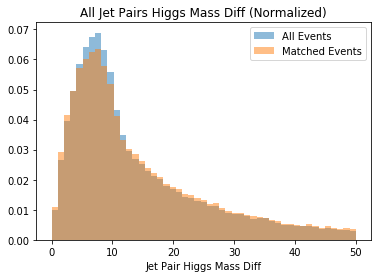

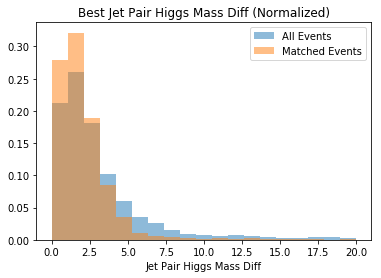

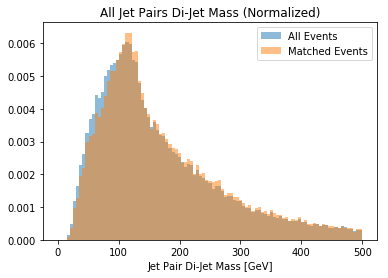

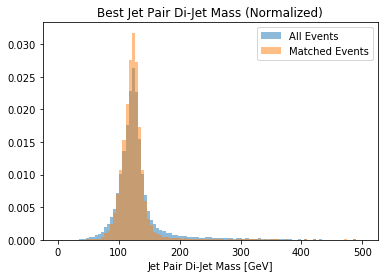

In [76]:
plotOpts = [] # title, xtitle, xMin, xMax, nBins
if pairingAlgorithm == 'minHarmonicMeanDeltaR':
    plotOpts = ['Delta R', 'Delta R', 0, 5.0, 100]
elif pairingAlgorithm == 'higgsMassDifference':
    plotOpts = ['Higgs Mass Diff', 'Higgs Mass Diff', 0, 100.0, 100]

    
#plotOneHistogram(allJetPairs_metric, 0, 'All Jet Pairs ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], plotOpts[2], plotOpts[3], plotOpts[4] )
#plotOneHistogram(allJetPairsWhenMatchable_metric, 1, 'All Jet Pairs ' + plotOpts[0] + ' (Matchable)', 'Jet Pair ' + plotOpts[1], plotOpts[2], plotOpts[3], plotOpts[4] )
#plotOneHistogram(bestJetPairs_metric, 2, 'Best Jet Pair ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], plotOpts[2], plotOpts[3], plotOpts[4] )
#plotOneHistogram(bestJetPairsWhenMatchable_metric, 3, 'Best Jet Pair ' + plotOpts[0] + ' (Matchable)', 'Jet Pair ' + plotOpts[1], plotOpts[2], plotOpts[3], plotOpts[4] )

# Compare shapes of metric variables for a) all events and b) matched events
if pairingAlgorithm == 'minHarmonicMeanDeltaR':
    compareTwoHistograms(allJetPairs_metric, allJetPairsWhenMatchable_metric, 4, 'All Jet Pairs ' + plotOpts[0] + ' (Normalized)', 'Jet Pair ' + plotOpts[1], int(plotOpts[2]/1.), int(plotOpts[3]/1.), int(plotOpts[4]/1.) )
    compareTwoHistograms(bestJetPairs_metric, bestJetPairsWhenMatchable_metric, 5, 'Best Jet Pair ' + plotOpts[0] + ' (Normalized)', 'Jet Pair ' + plotOpts[1], int(plotOpts[2]/1.), int(plotOpts[3]/1.), int(plotOpts[4]/1.) )
elif pairingAlgorithm == 'higgsMassDifference':
    compareTwoHistograms(allJetPairs_metric, allJetPairsWhenMatchable_metric, 4, 'All Jet Pairs ' + plotOpts[0] + ' (Normalized)', 'Jet Pair ' + plotOpts[1], plotOpts[2], int(plotOpts[3]/2.), int(plotOpts[4]/2.) )
    compareTwoHistograms(bestJetPairs_metric, bestJetPairsWhenMatchable_metric, 5, 'Best Jet Pair ' + plotOpts[0] + ' (Normalized)', 'Jet Pair ' + plotOpts[1], plotOpts[2], int(plotOpts[3]/5.), int(plotOpts[4]/5.) )

# Look at higgs mass plots
#plotOneHistogram(allHiggsMasses_metric, 6, 'All Jet Pairs Di-Jet Mass', 'Di-Jet Mass [GeV]', 0, 500, 100 )
compareTwoHistograms(allHiggsMasses_metric, allHiggsMassesWhenMatchable_metric, 4, 'All Jet Pairs Di-Jet Mass (Normalized)', 'Jet Pair Di-Jet Mass [GeV]', 0, 500, 100 )
compareTwoHistograms(bestHiggsMasses_metric, bestHiggsMassesWhenMatchable_metric, 4, 'Best Jet Pair Di-Jet Mass (Normalized)', 'Jet Pair Di-Jet Mass [GeV]', 0, 500, 100 )


In [59]:
import itertools
a=[1,2,3,4,5,6,7]
pairs = list(itertools.combinations(a,2))
#list(pairs)
pairPairs = {}
for two in pairs:
    notwo = [x for x in list(pairs) if two[0] not in x and two[1] not in x]
    for pairOption in notwo:
        sortedPairing = sorted([sorted(x) for x in [two, pairOption]])
        sortedTuple = tuple(sortedPairing[0]+sortedPairing[1])

        if sortedTuple not in pairPairs.keys():
            pairPairs[sortedTuple]=0

print(len(pairPairs))
print(pairPairs)
    